# CytoDataFrame at a Glance

This notebook demonstrates various capabilities of
[CytoDataFrame](https://github.com/WayScience/CytoDataFrame) using examples.

CytoDataFrame is intended to provide you a Pandas-like
DataFrame experience which is enhanced with single-cell
visual information which can be viewed directly in a Jupyter notebook.

In [1]:
from cytodataframe.frame import CytoDataFrame

# create paths for use with CytoDataFrames below
jump_data_path = "../../../tests/data/cytotable/JUMP_plate_BR00117006"
nf1_cellpainting_path = "../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/"
nuclear_speckles_path = "../../../tests/data/cytotable/nuclear_speckles"
pediatric_cancer_atlas_path = (
    "../../../tests/data/cytotable/pediatric_cancer_atlas_profiling"
)

CPU times: user 830 ms, sys: 627 ms, total: 1.46 s
Wall time: 382 ms


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

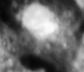
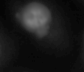
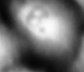
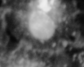
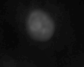
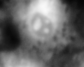
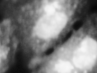
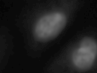
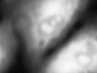

In [2]:
%%time
# view JUMP plate BR00117006 with images
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:3]

CPU times: user 666 ms, sys: 371 ms, total: 1.04 s
Wall time: 326 ms
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 15119
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 15119
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 15119
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 44963
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 44963
HERE
Outline image shape: (1080, 1080)
Outline image unique values: [  0 255]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 44963


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

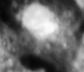
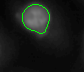
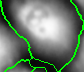
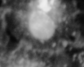
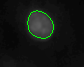
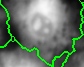
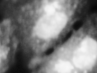
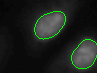
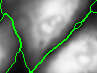

In [3]:
%%time
# view JUMP plate BR00117006 with images and overlaid outlines for segmentation
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
    data_outline_context_dir=f"{jump_data_path}/images/outlines",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:3]

CPU times: user 200 ms, sys: 98.9 ms, total: 299 ms
Wall time: 104 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

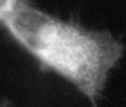
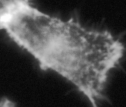
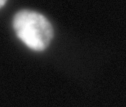
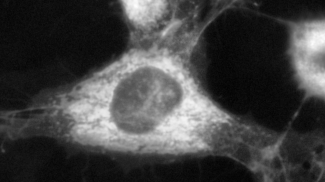
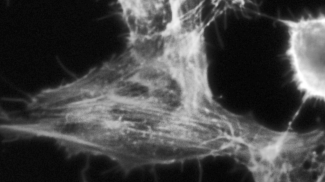
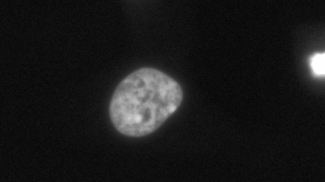
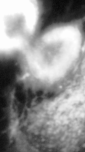
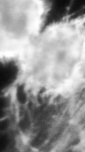
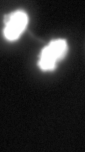

In [4]:
%%time
# view NF1 Cell Painting data with images
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][:3]

CPU times: user 213 ms, sys: 116 ms, total: 328 ms
Wall time: 101 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

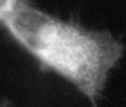
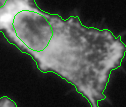
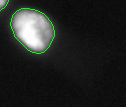
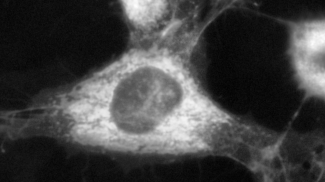
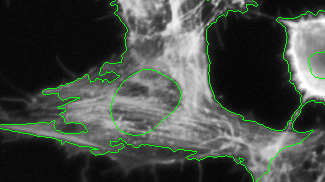
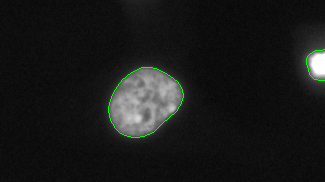
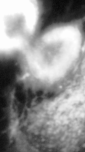
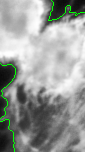
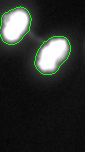

In [5]:
%%time
# view NF1 Cell Painting data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
    data_mask_context_dir=f"{nf1_cellpainting_path}/Plate_2_masks",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][:3]

CPU times: user 96.6 ms, sys: 53.1 ms, total: 150 ms
Wall time: 47.2 ms


,Metadata_ImageNumber,Nuclei_Number_Object_Number,Image_FileName_A647,Image_FileName_DAPI,Image_FileName_GOLD
0,1,1,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
1,1,2,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
2,1,3,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff

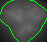
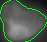

In [6]:
%%time
# view nuclear speckles data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nuclear_speckles_path}/test_slide1_converted.parquet",
    data_context_dir=f"{nuclear_speckles_path}/images/plate1",
    data_mask_context_dir=f"{nuclear_speckles_path}/masks/plate1",
)[
    [
        "Metadata_ImageNumber",
        "Nuclei_Number_Object_Number",
        "Image_FileName_A647",
        "Image_FileName_DAPI",
        "Image_FileName_GOLD",
    ]
][:3]

CPU times: user 280 ms, sys: 171 ms, total: 451 ms
Wall time: 128 ms
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 10223
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 10223
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 10223
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 4477
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mask sum (true values): 4477
HERE
Outline image shape: (1080, 1080, 3)
Outline image unique values: [    0 32896]
Non-black mask shape: (1080, 1080)
Non-black mas

,Metadata_ImageNumber,Metadata_Nuclei_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA
0,3,3,,
1,3,4,,
2,3,6,,

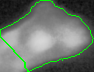
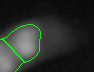
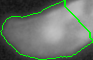
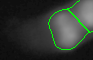
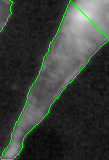
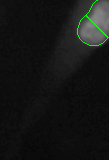

In [7]:
%%time
# view ALSF pediatric cancer atlas plate BR00143976 with images
CytoDataFrame(
    data=f"{pediatric_cancer_atlas_path}/BR00143976_shrunken.parquet",
    data_context_dir=f"{pediatric_cancer_atlas_path}/images/orig",
    data_outline_context_dir=f"{pediatric_cancer_atlas_path}/images/outlines",
    segmentation_file_regex={
        r"CellsOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch3.*\.tiff",
        r"NucleiOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch5.*\.tiff",
    },
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Nuclei_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
    ]
][:3]